In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'NHY.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,19698,-12970,6728,666,6045,0,10334,29750,0,...,0,0,5007,16500,4850,45159,1151,-871,2039,2014-10-25
1,2014-12-31,21656,-13697,7959,-166,9253,0,12642,35927,0,...,0,0,6039,19116,5128,52243,4386,-1133,2039,2015-02-14
2,2015-03-31,23290,-14662,8628,1071,7172,0,13392,38413,0,...,0,0,4239,19204,5722,51077,1095,-847,2041,2015-04-25
3,2015-06-30,22436,-14374,8062,2064,8142,0,12722,37252,0,...,0,0,3683,17957,5013,48589,4449,-1122,2041,2015-07-25
4,2015-09-30,21594,-14361,7233,-1344,9372,0,11996,38036,0,...,0,0,3509,18061,4408,48381,4427,-1182,2041,2015-10-25


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-10-25,2026,44702,-30501,14201,-625,19105,0,27648,...,10823,205260,24860,0,5764,41718,29944,102197,5088,-3200
37,2023-12-31,2024-02-14,2020,46754,-29633,17121,-2772,24618,0,25449,...,8447,206462,0,0,7111,43892,28978,105884,3130,-4329
38,2024-03-31,2024-04-22,2006,47545,-30025,17520,428,19622,28969,25291,...,8741,213133,26541,0,8169,42768,30996,101384,-80,-3078
39,2024-06-30,2024-07-22,2005,50944,-33410,17534,1421,18886,28689,25208,...,8365,205213,26336,0,16249,51147,22867,101371,4178,-3240
40,2024-09-30,2024-10-21,1995,50722,-32099,18623,1409,18875,28809,26127,...,8334,206755,26130,0,13935,49540,23864,101255,4655,-2867


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-10-25,2026,44702,-30501,14201,-625,19105,0,27648,...,205260,24860,0,5764,41718,29944,102197,5088,-3200,10.483742
37,2023-12-31,2024-02-14,2020,46754,-29633,17121,-2772,24618,0,25449,...,206462,0,0,7111,43892,28978,105884,3130,-4329,10.821103
38,2024-03-31,2024-04-22,2006,47545,-30025,17520,428,19622,28969,25291,...,213133,26541,0,8169,42768,30996,101384,-80,-3078,10.502364
39,2024-06-30,2024-07-22,2005,50944,-33410,17534,1421,18886,28689,25208,...,205213,26336,0,16249,51147,22867,101371,4178,-3240,10.750878
40,2024-09-30,2024-10-21,1995,50722,-32099,18623,1409,18875,28809,26127,...,206755,26130,0,13935,49540,23864,101255,4655,-2867,10.704589


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-10-25,2026,44702,-30501,14201,-625,19105,0,27648,...,205260,24860,0,5764,41718,29944,102197,5088,-3200,10.483742
37,2023-12-31,2024-02-14,2020,46754,-29633,17121,-2772,24618,0,25449,...,206462,0,0,7111,43892,28978,105884,3130,-4329,10.821103
38,2024-03-31,2024-04-22,2006,47545,-30025,17520,428,19622,28969,25291,...,213133,26541,0,8169,42768,30996,101384,-80,-3078,10.502364
39,2024-06-30,2024-07-22,2005,50944,-33410,17534,1421,18886,28689,25208,...,205213,26336,0,16249,51147,22867,101371,4178,-3240,10.750878
40,2024-09-30,2024-10-21,1995,50722,-32099,18623,1409,18875,28809,26127,...,206755,26130,0,13935,49540,23864,101255,4655,-2867,10.704589


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-10-27,23.533808,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.604822,0.395178,0.0,0.0,0.0,0.0,0.341558,0.033811,0.0,0.0
1,2014-11-03,23.596159,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.604822,0.395178,0.0,0.0,0.0,0.0,0.341558,0.033811,0.0,0.0
2,2014-11-10,24.419277,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.604822,0.395178,0.0,0.0,0.0,0.0,0.341558,0.033811,0.0,0.0
3,2014-11-17,25.448187,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.604822,0.395178,0.0,0.0,0.0,0.0,0.341558,0.033811,0.0,0.0
4,2014-11-24,25.616552,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.604822,0.395178,0.0,0.0,0.0,0.0,0.341558,0.033811,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-10-27,23.533808,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.0,0.341558,0.033811,0.0,0.0,inf,0.694274,inf,inf,inf
1,2014-11-03,23.596159,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.0,0.341558,0.033811,0.0,0.0,inf,0.696113,inf,inf,inf
2,2014-11-10,24.419277,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.0,0.341558,0.033811,0.0,0.0,inf,0.720396,inf,inf,inf
3,2014-11-17,25.448187,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.0,0.341558,0.033811,0.0,0.0,inf,0.750750,inf,inf,inf
4,2014-11-24,25.616552,2014-09-30,19698.0,0.0,33.897008,2039.0,0.0,0.0,6045.0,...,0.0,0.341558,0.033811,0.0,0.0,inf,0.755717,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

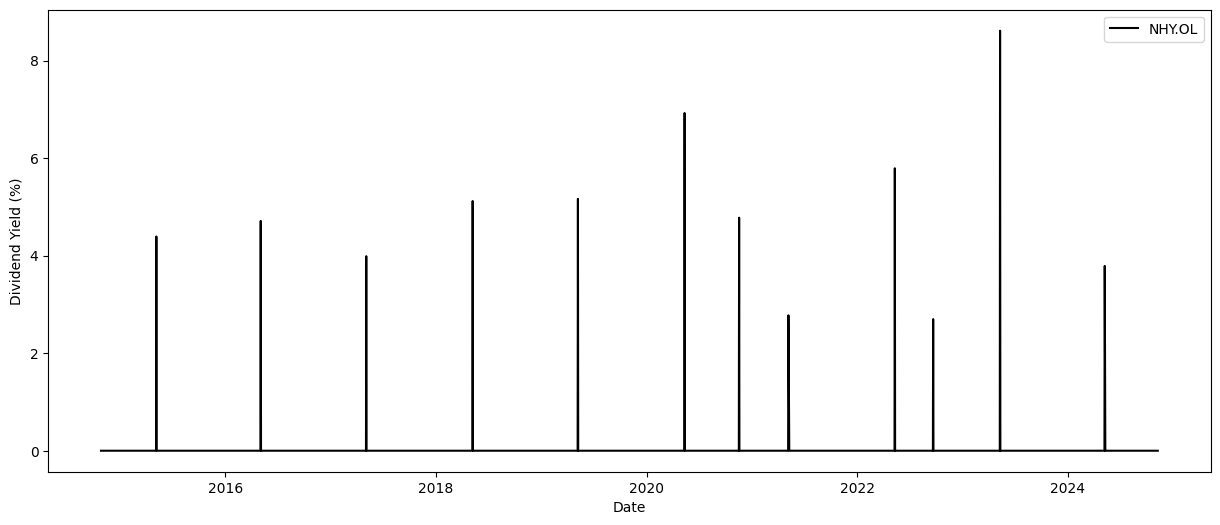

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.63954
share_price      1.00000
Name: share_price, dtype: float64


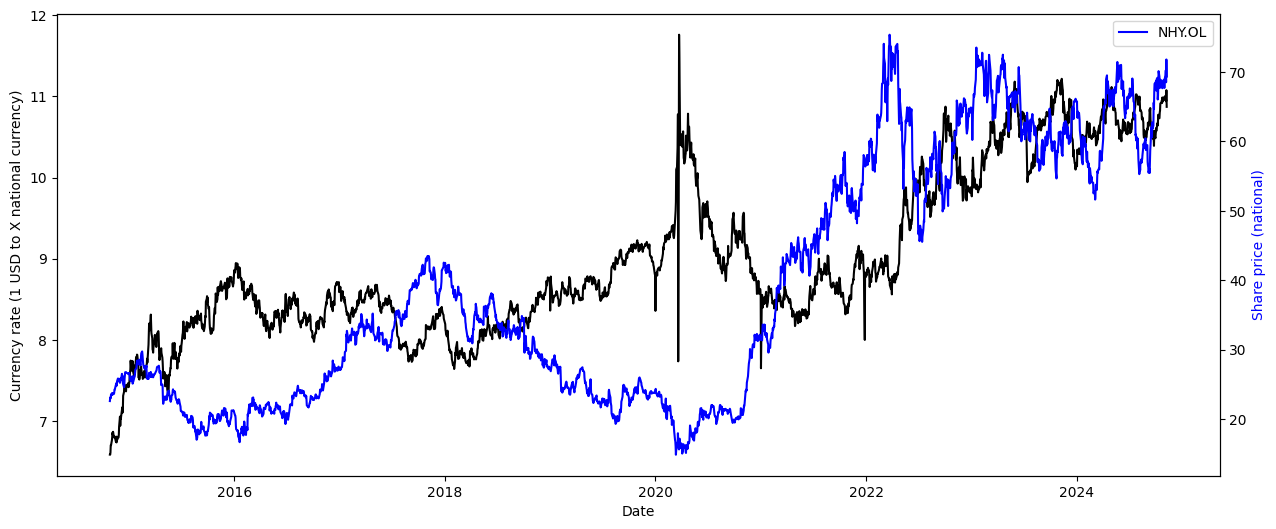

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

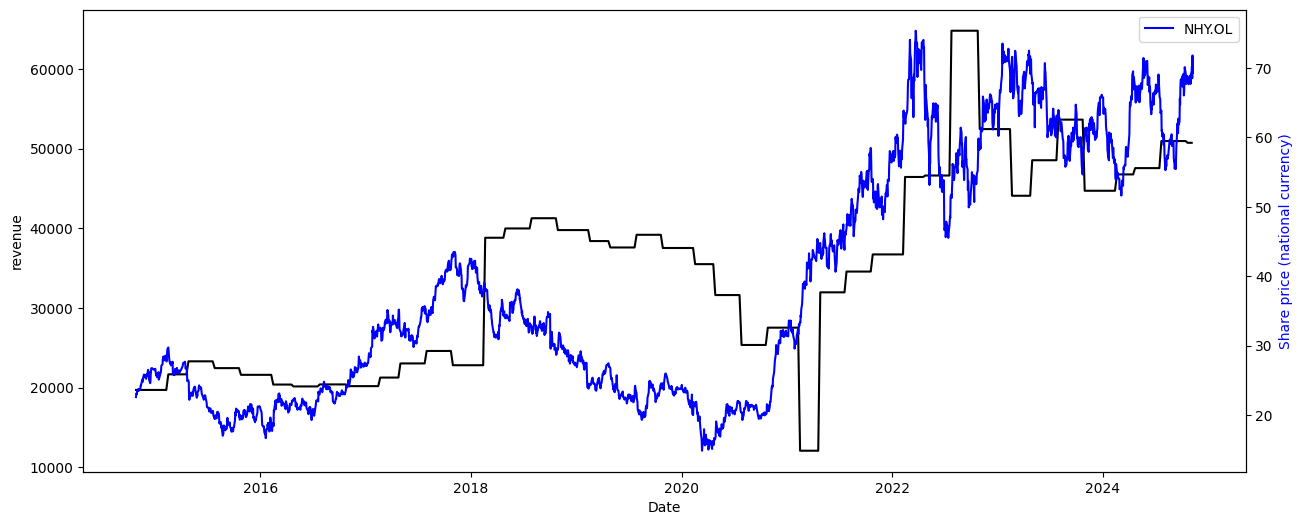

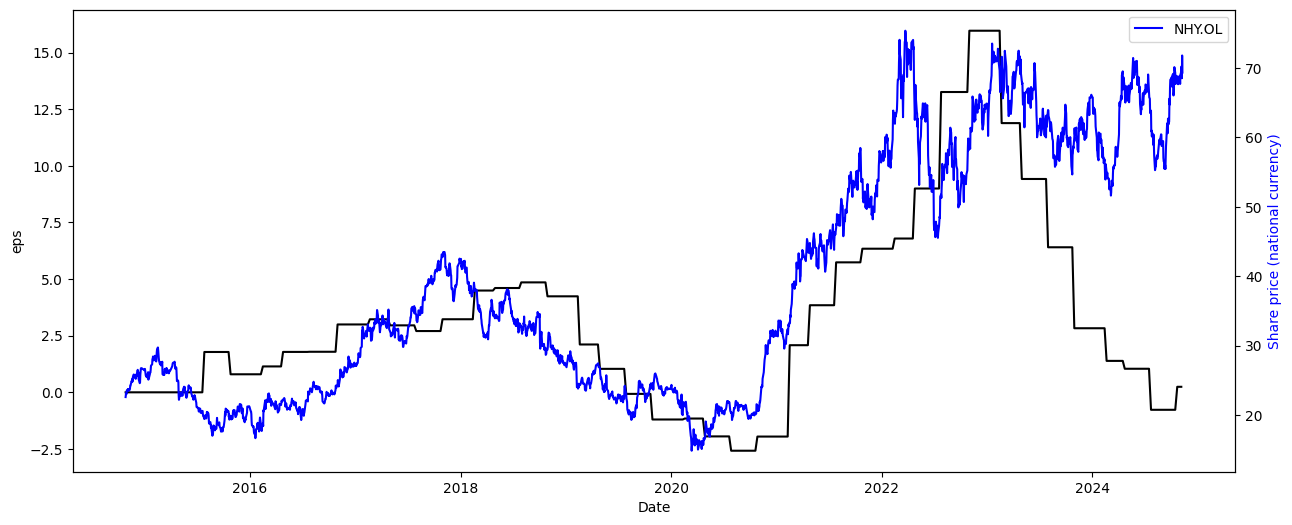

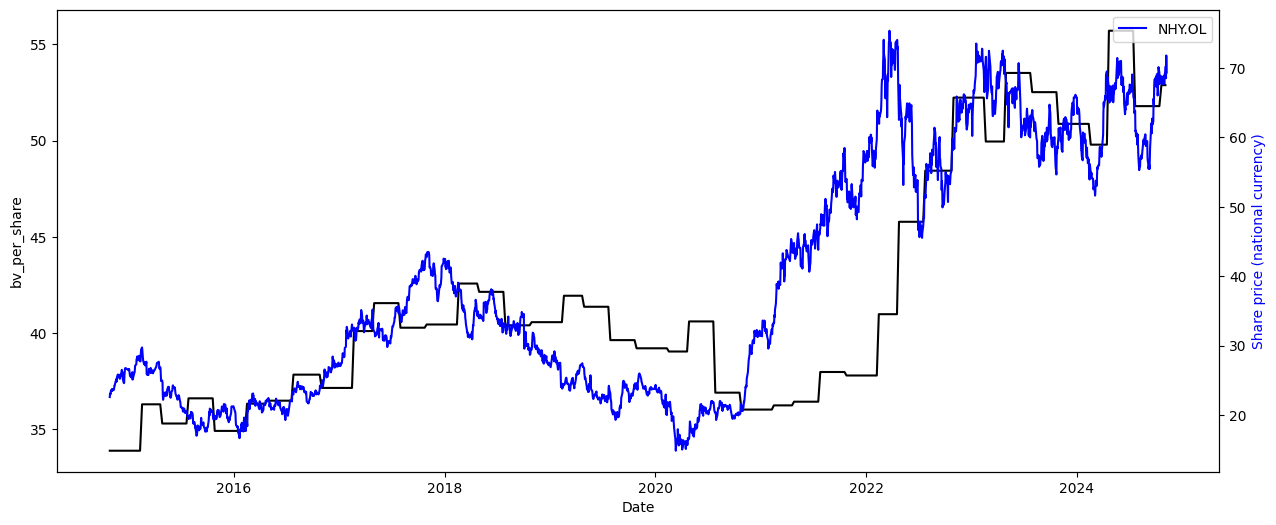

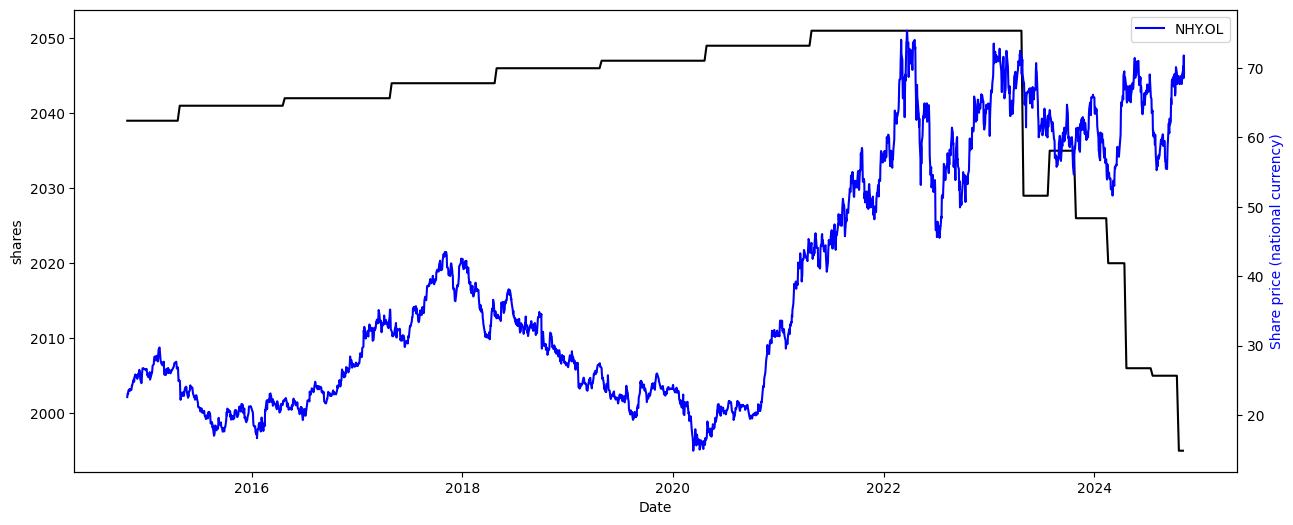

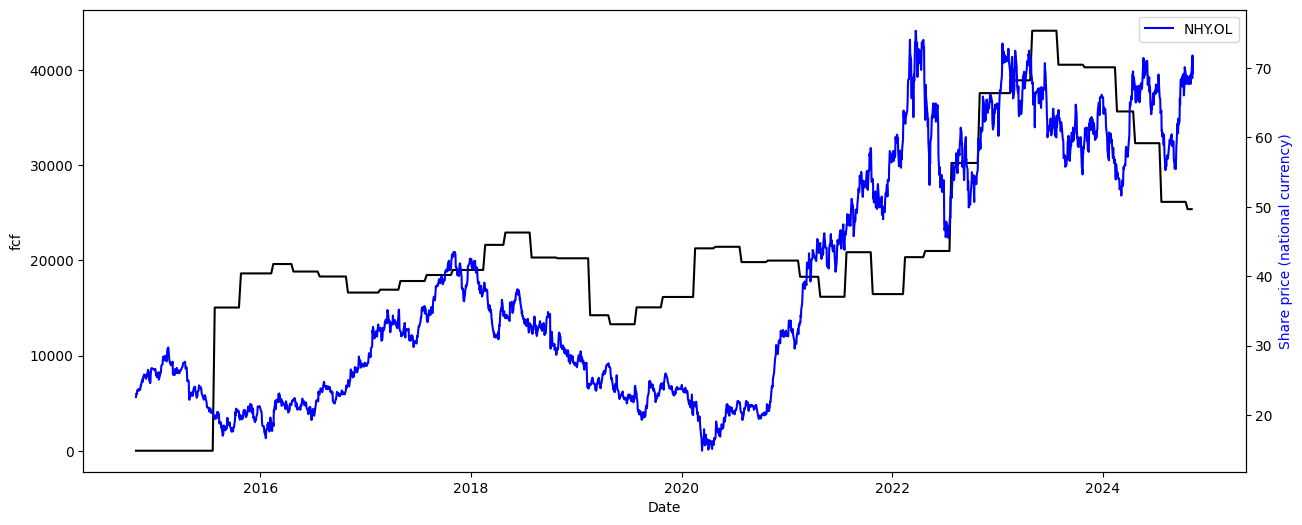

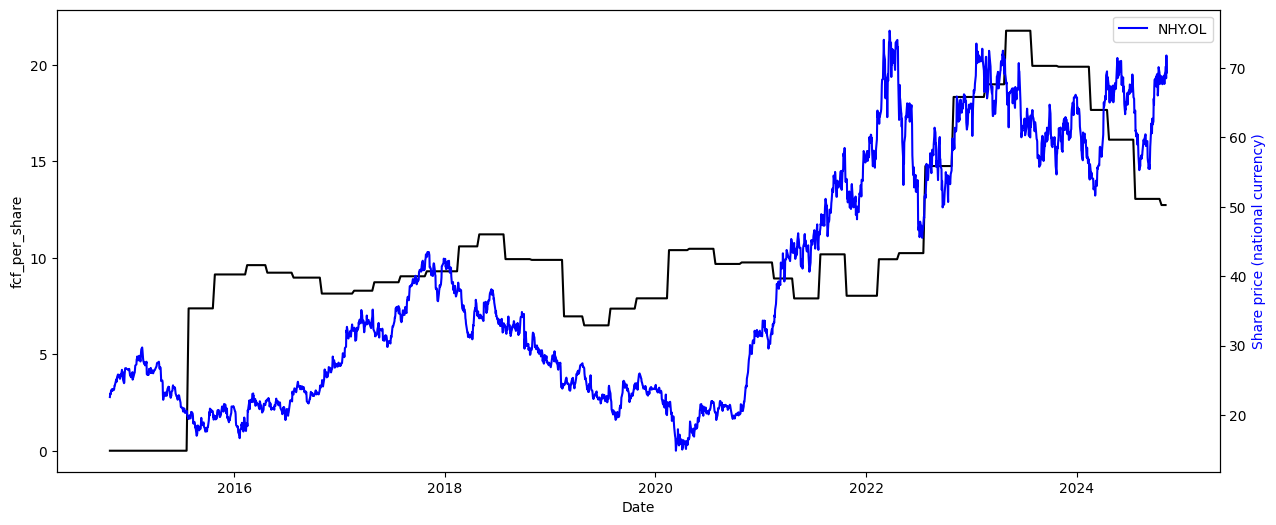

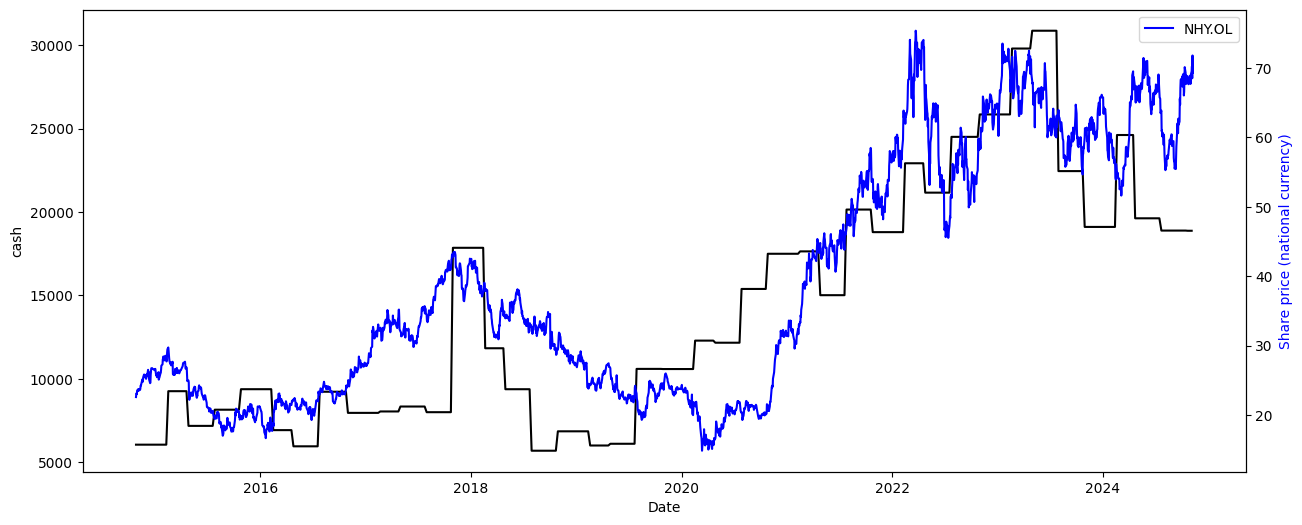

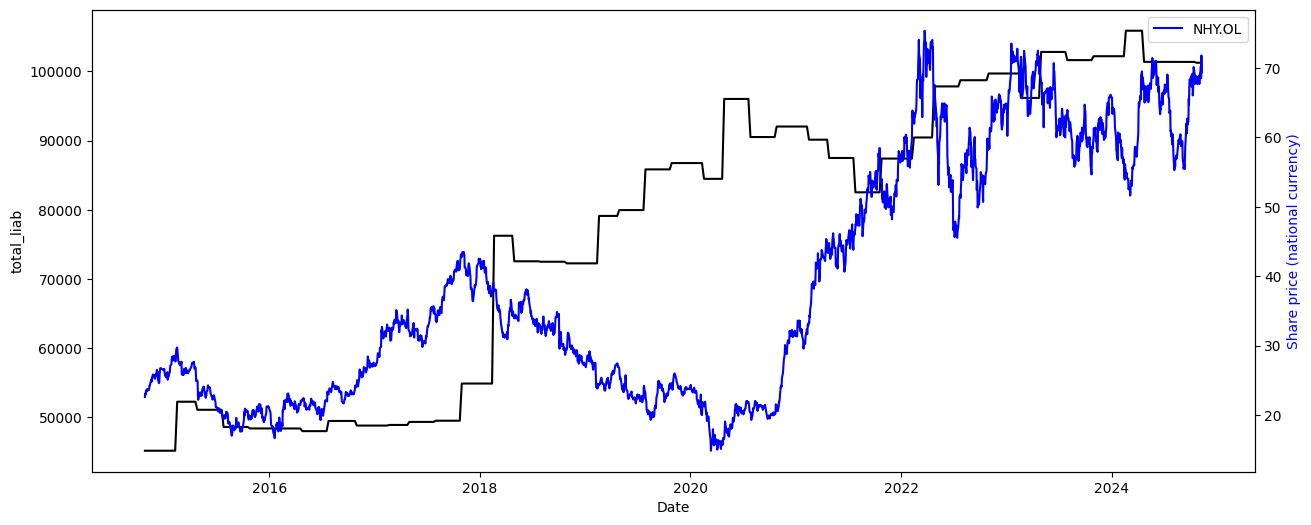

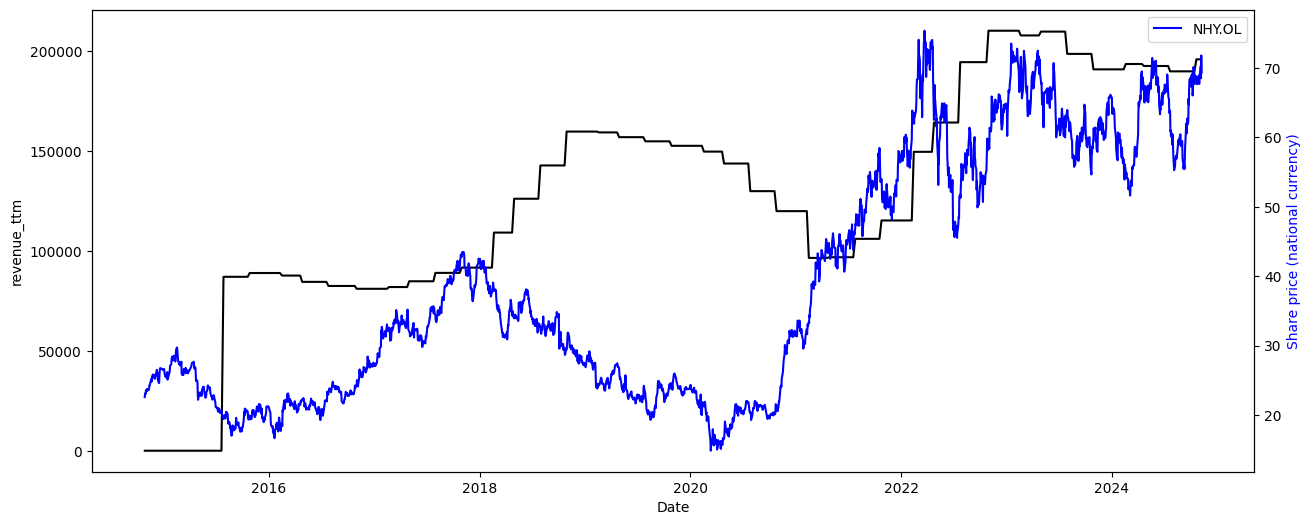

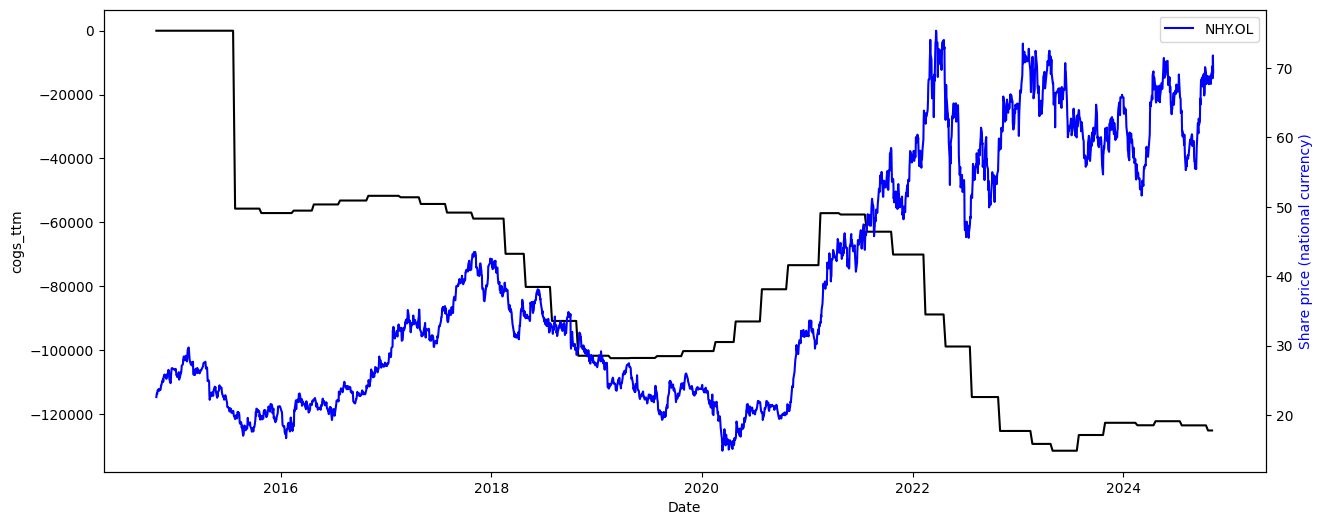

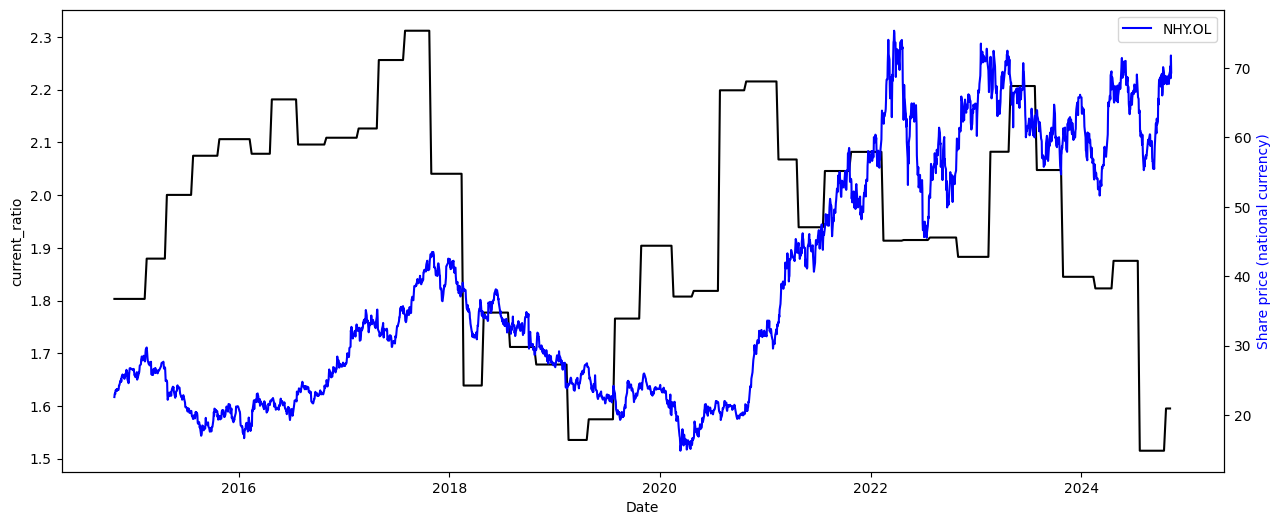

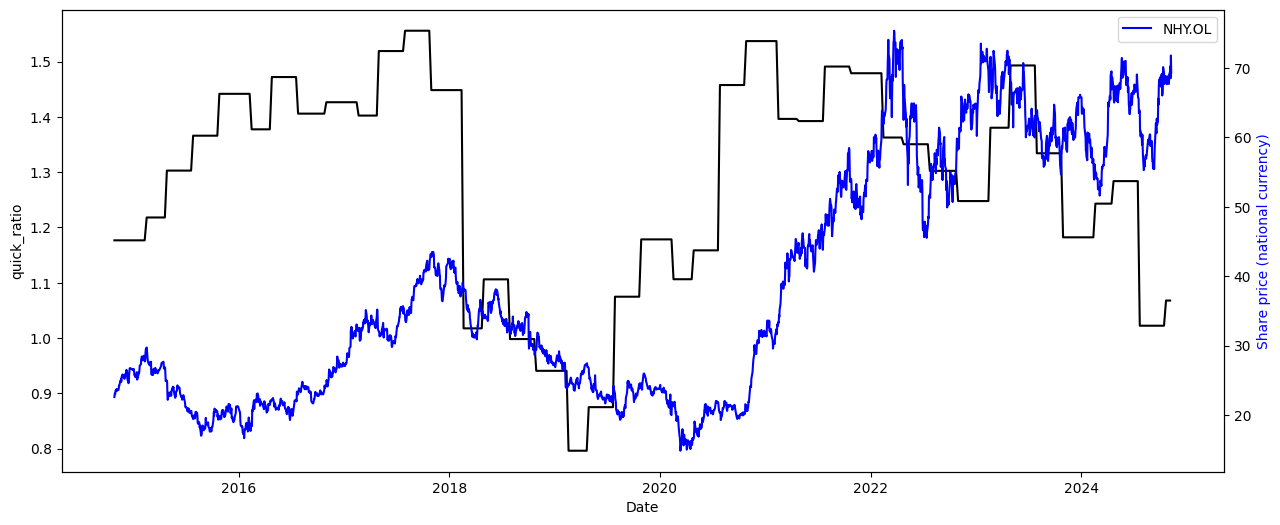

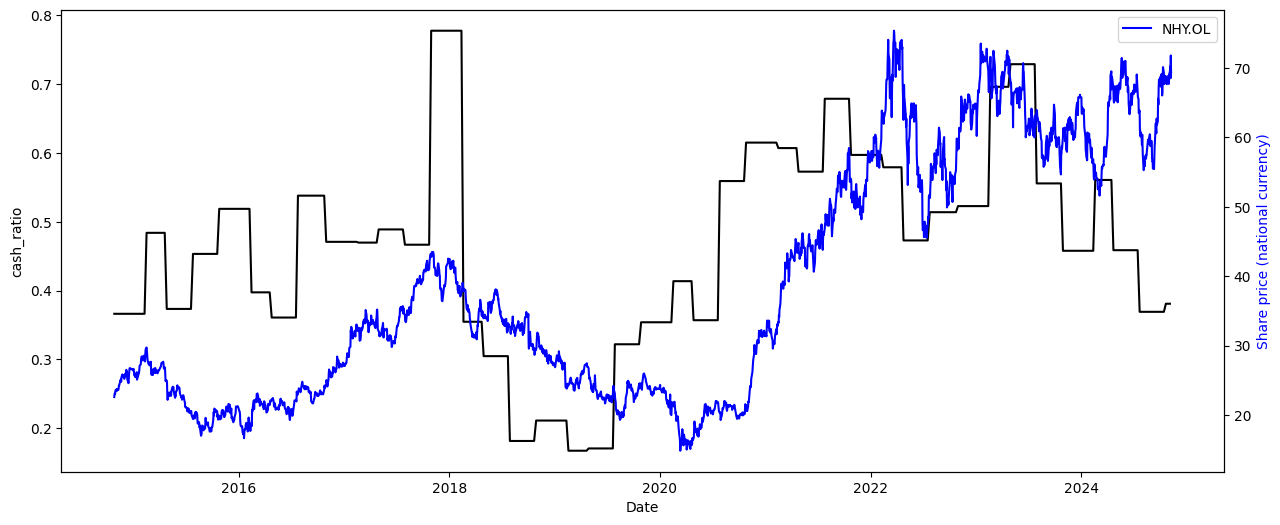

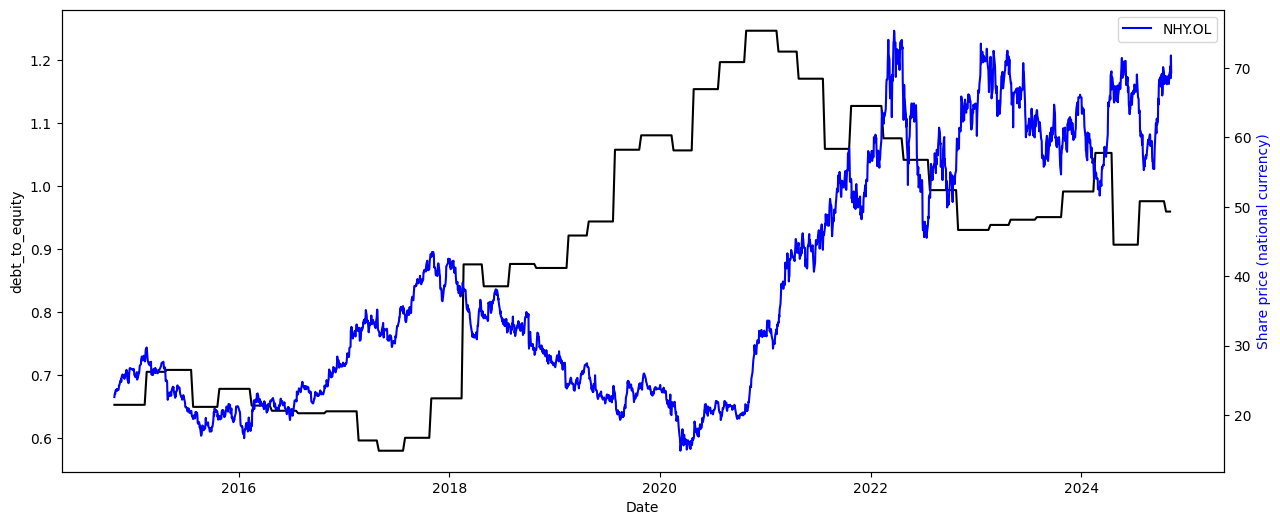

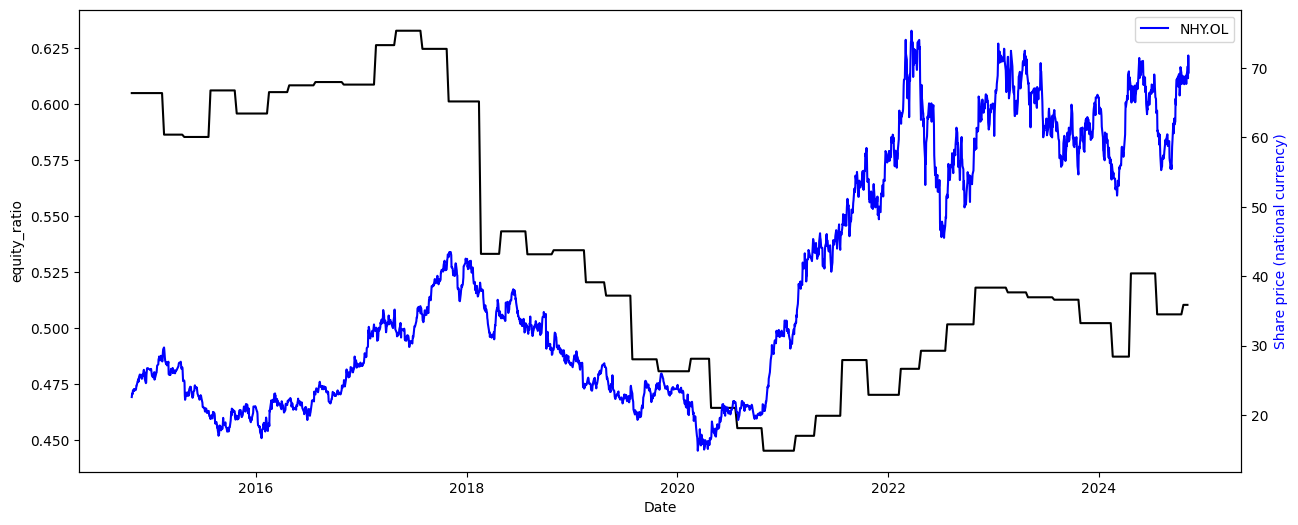

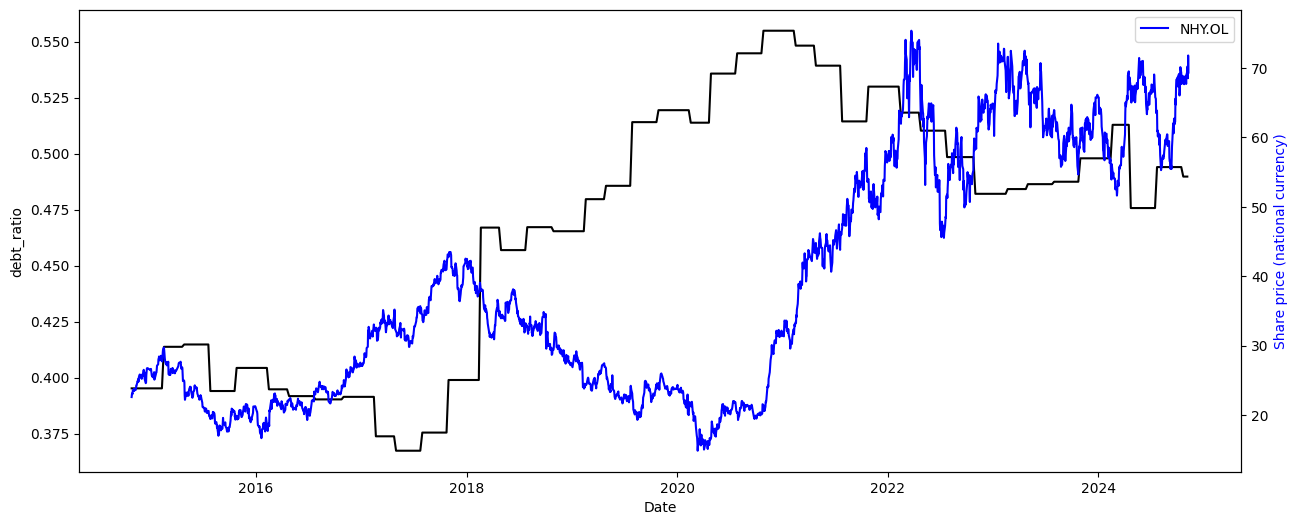

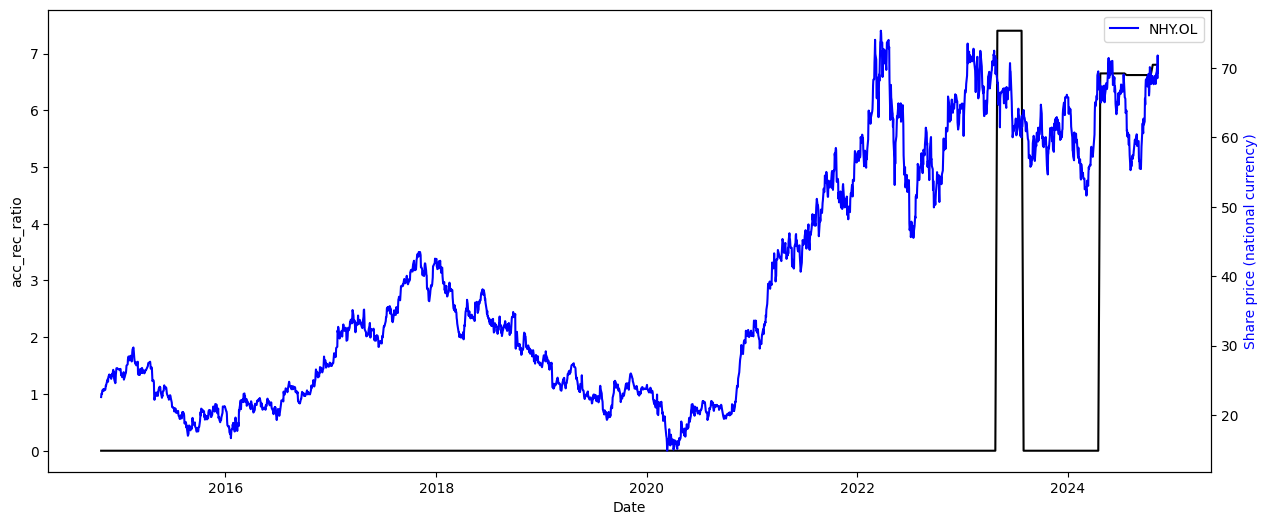

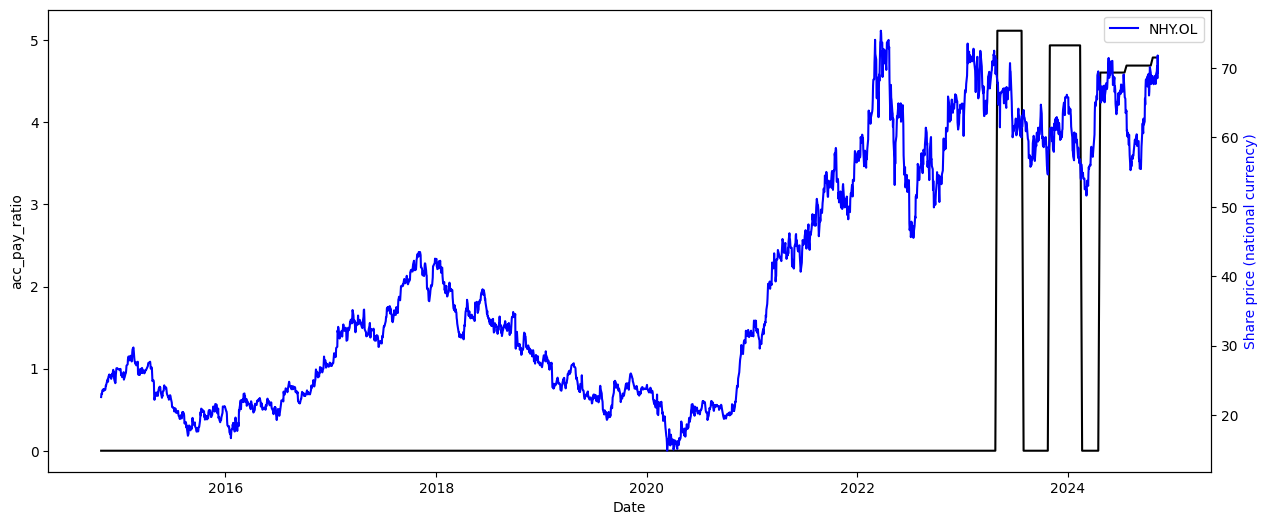

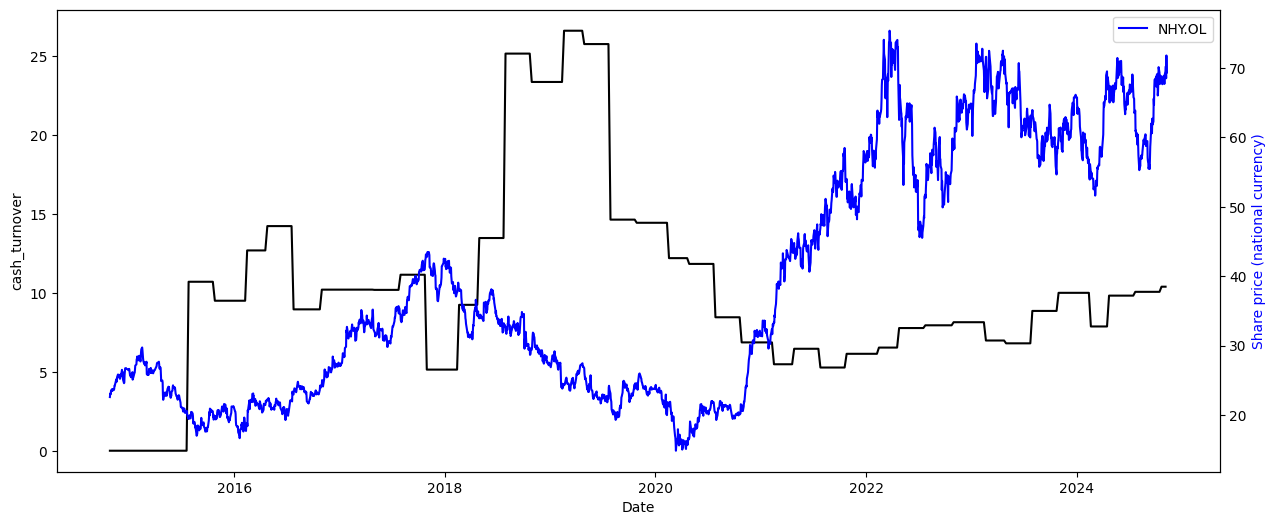

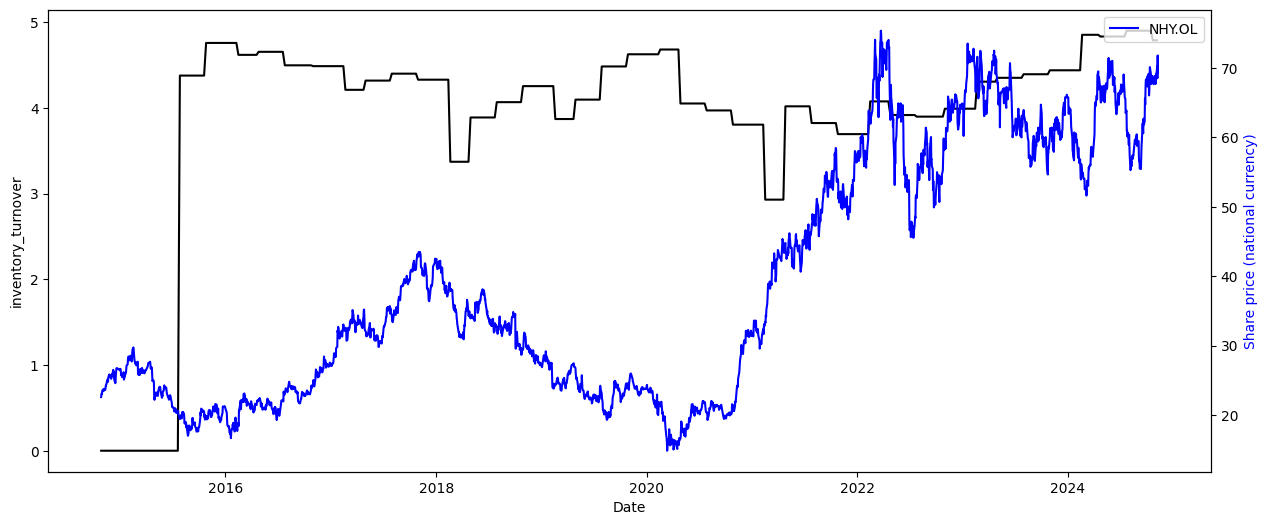

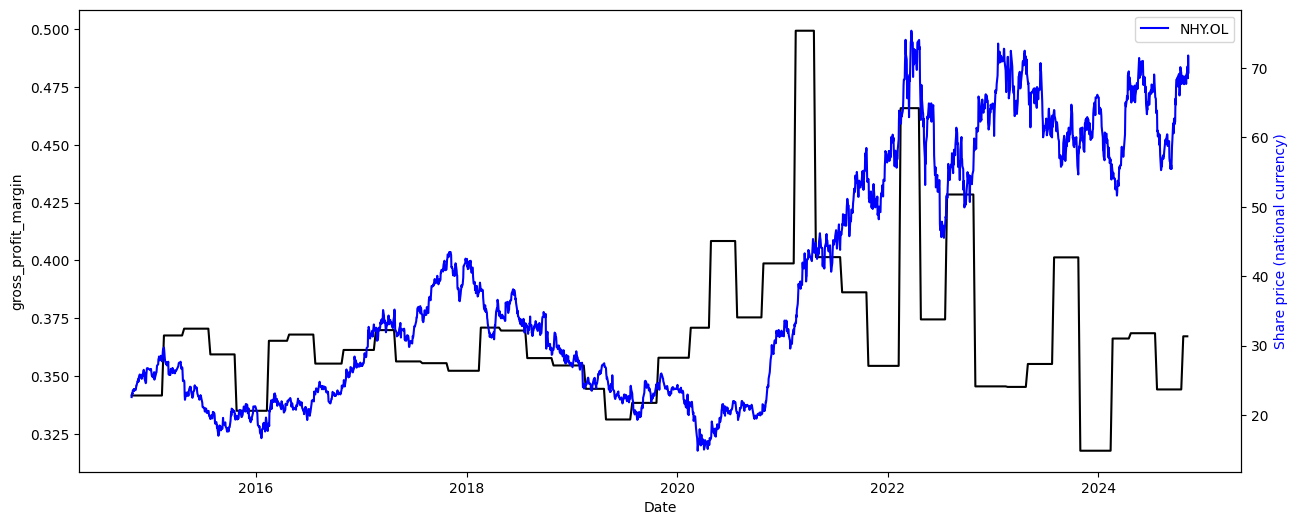

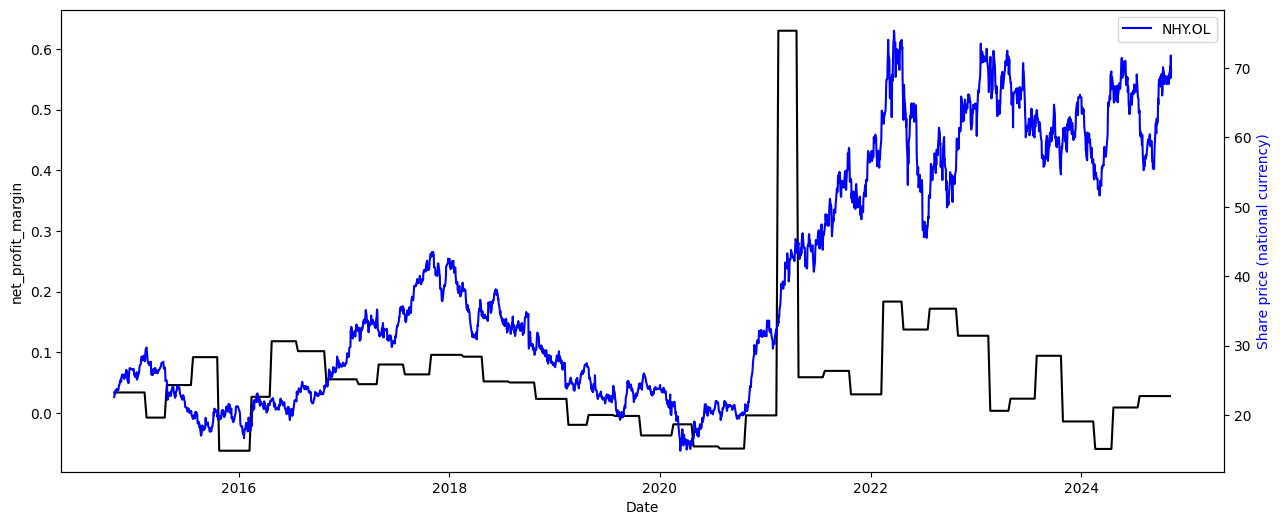

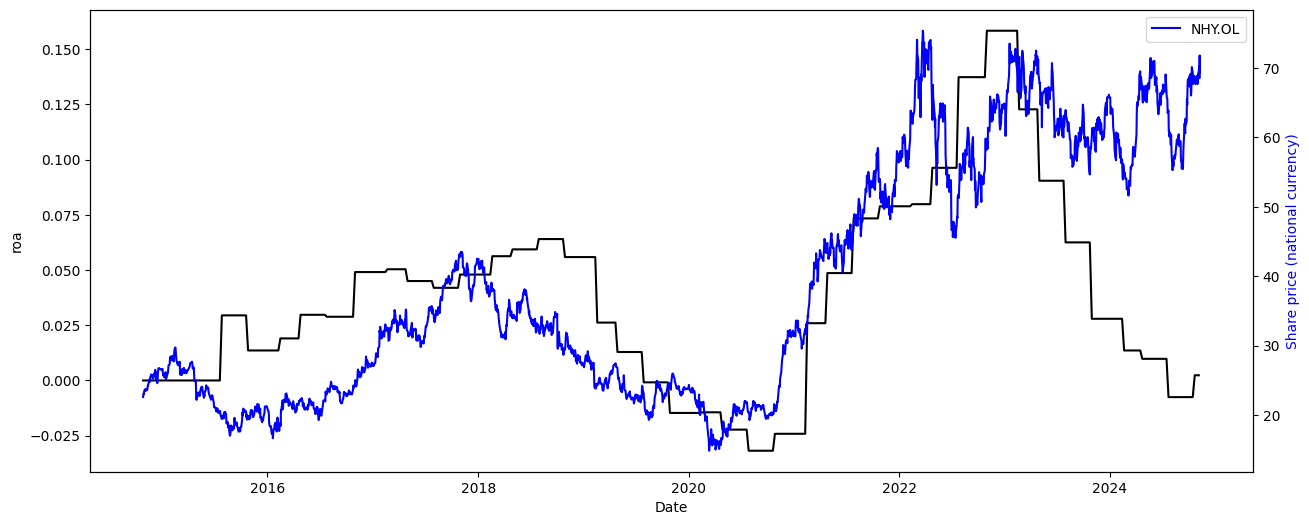

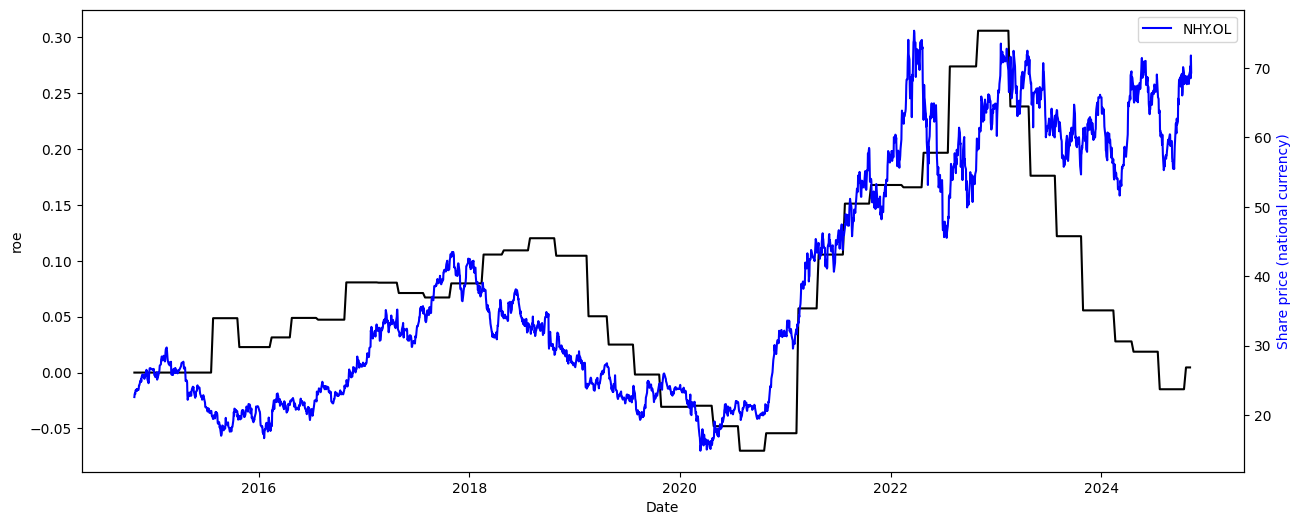

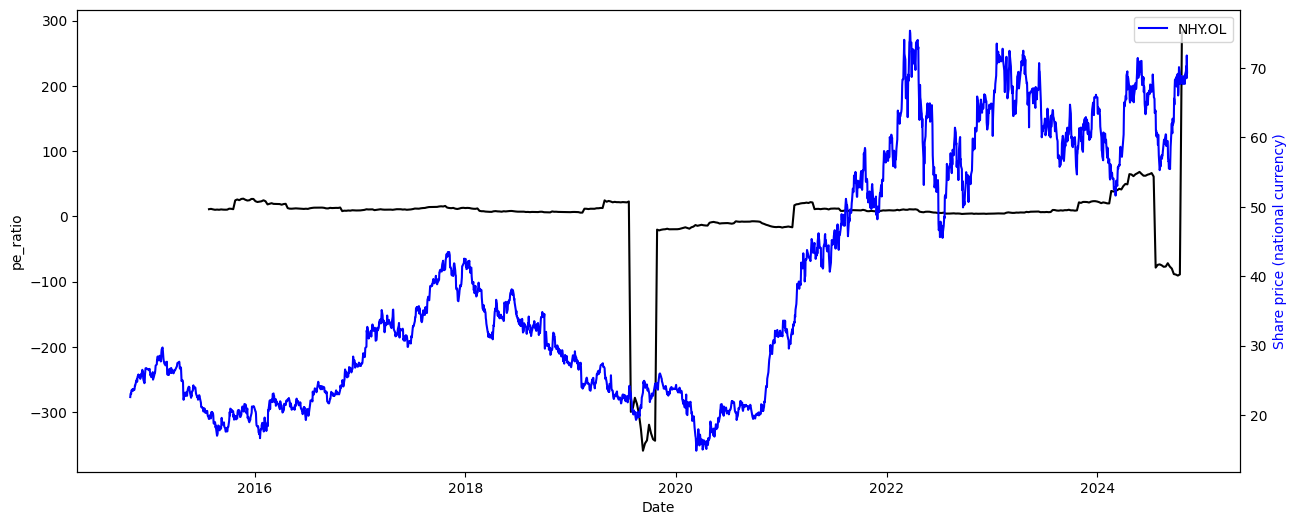

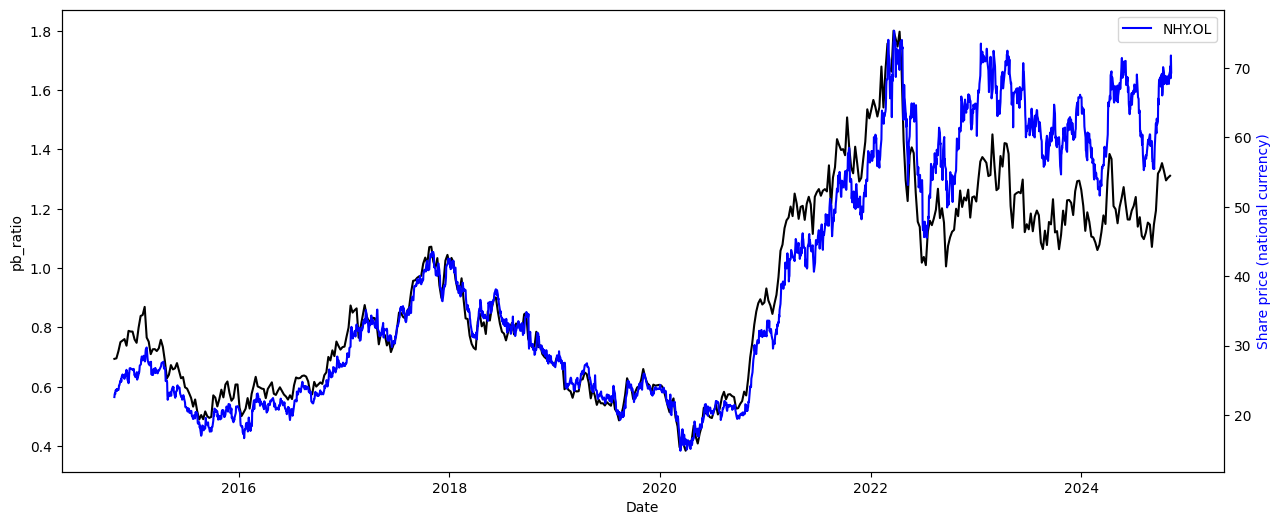

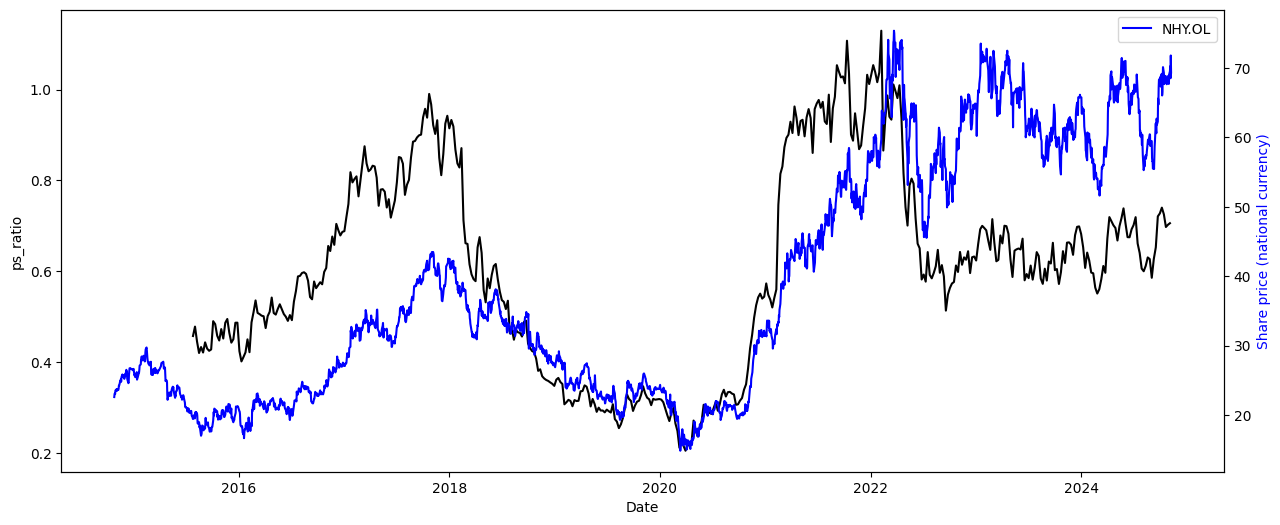

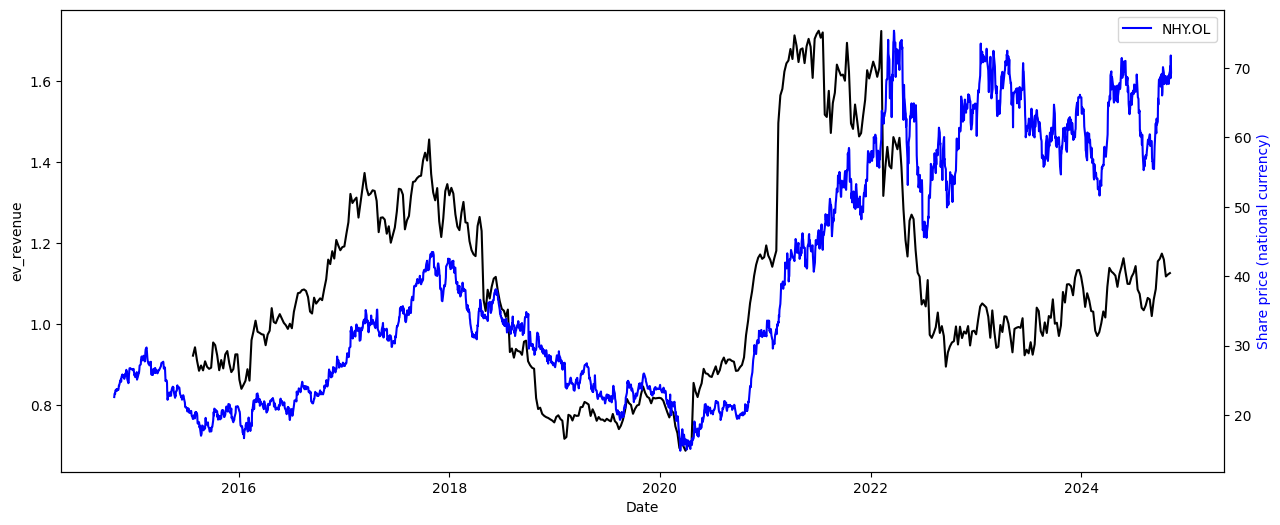

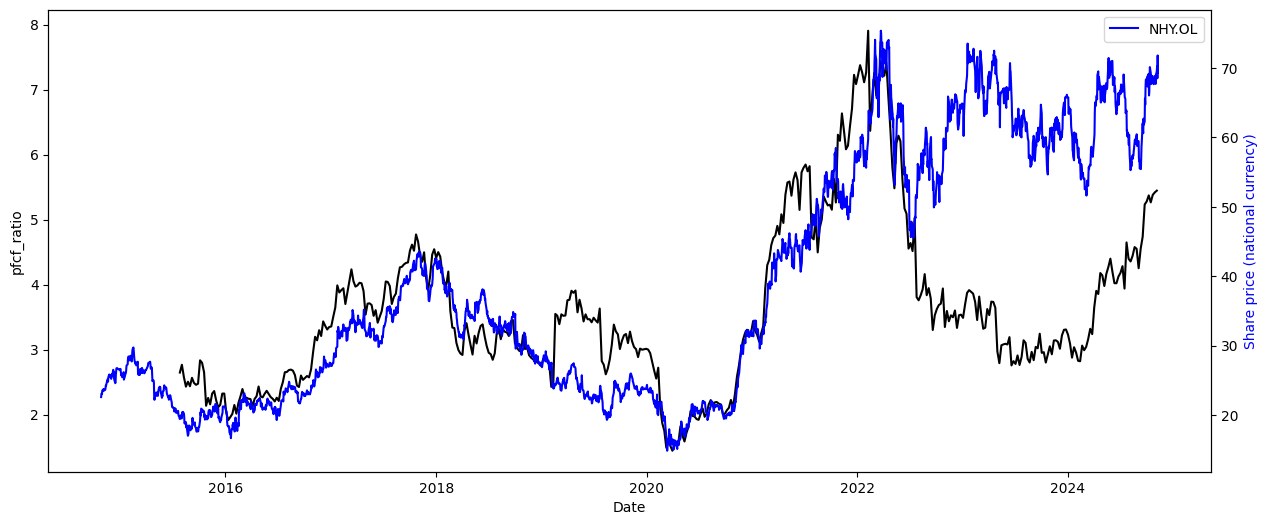

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

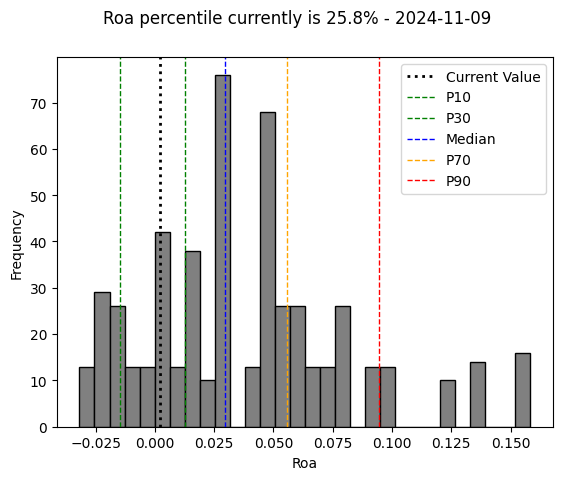

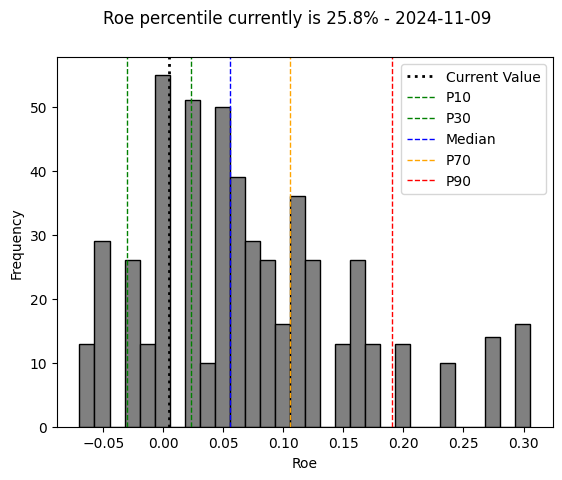

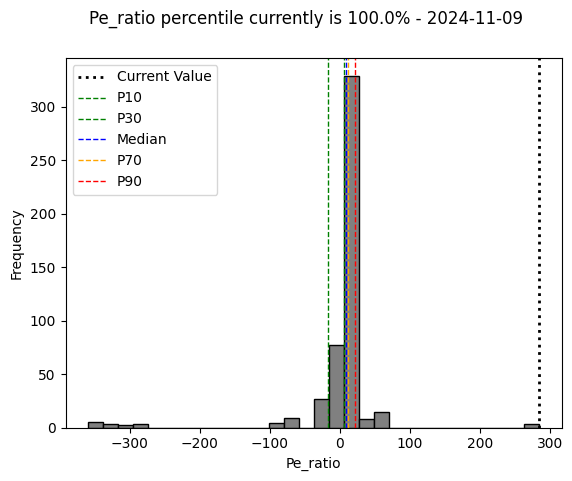

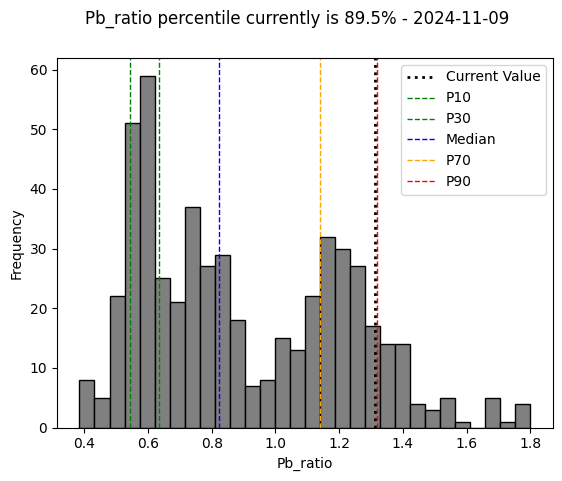

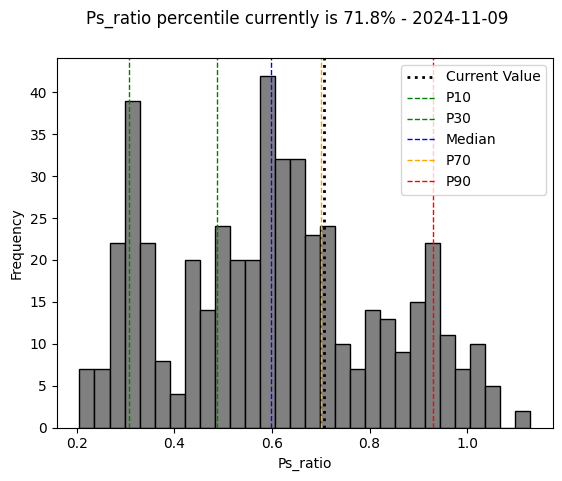

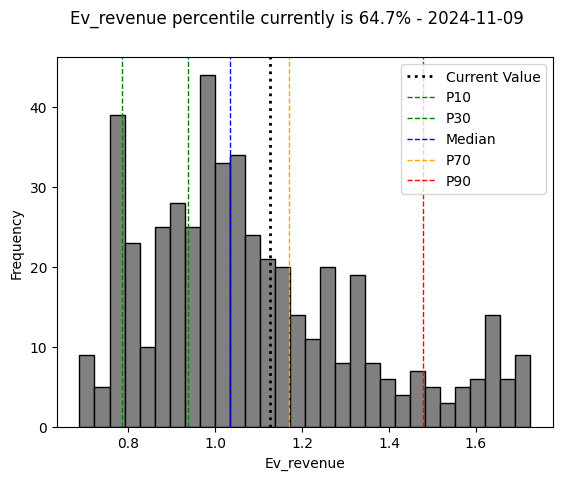

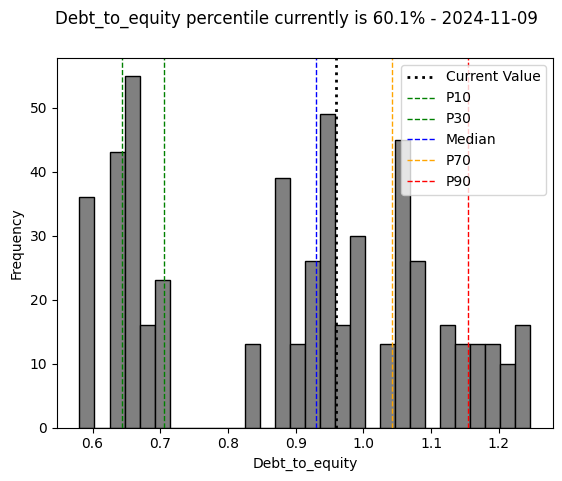

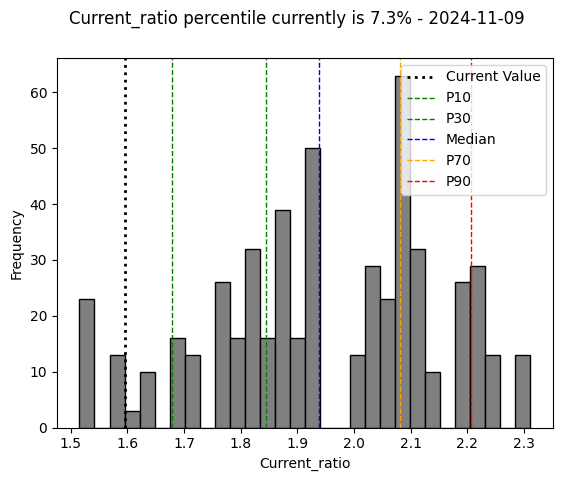

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.996622,0.174493,0.598361,0.456191,0.250754,-0.051306,0.081895
roe,0.996622,1.000000,0.167185,0.631158,0.462223,0.266200,0.003940,0.052962
pe_ratio,0.174493,0.167185,1.000000,0.215797,0.279262,0.223795,-0.186807,0.149365
pb_ratio,0.598361,0.631158,0.215797,1.000000,0.778940,0.639511,0.338028,0.047830
ps_ratio,0.456191,0.462223,0.279262,0.778940,1.000000,0.932829,-0.092547,0.361468
ev_revenue,0.250754,0.266200,0.223795,0.639511,0.932829,1.000000,0.069996,0.363445
debt_to_equity,-0.051306,0.003940,-0.186807,0.338028,-0.092547,0.069996,1.000000,-0.222278
current_ratio,0.081895,0.052962,0.149365,0.047830,0.361468,0.363445,-0.222278,1.000000


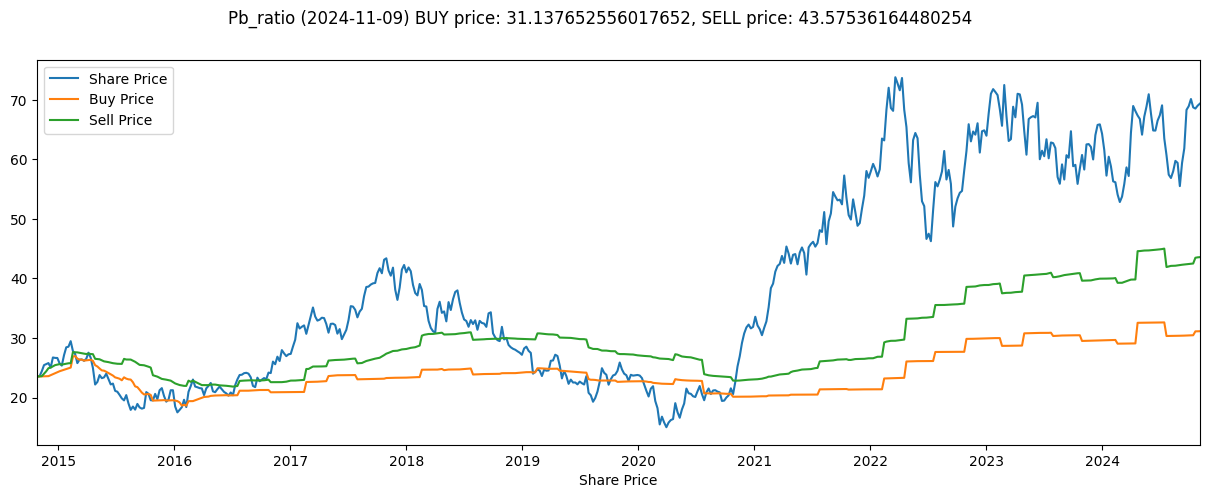

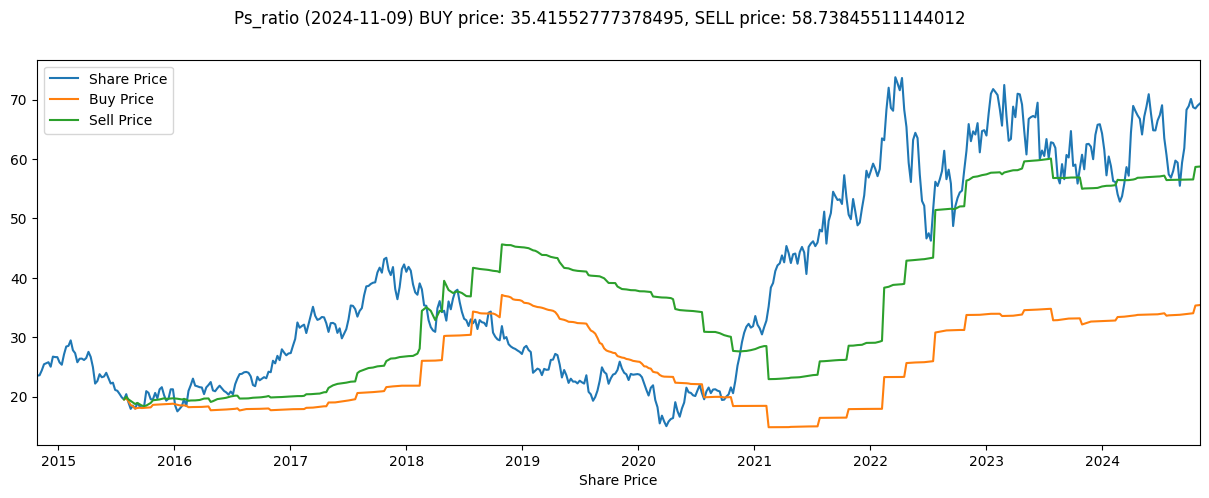

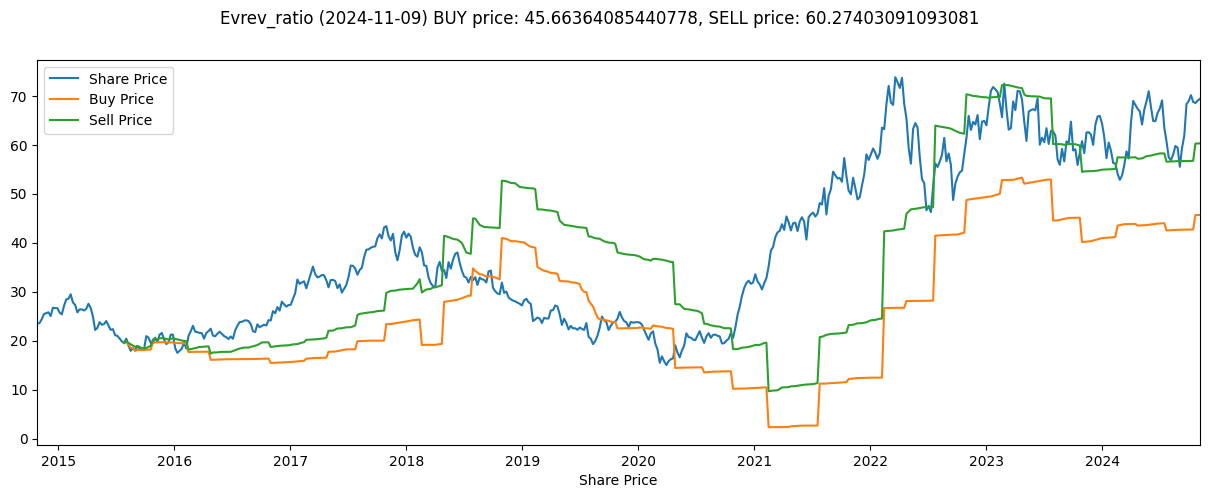

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)